In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')


# Imports 

In [2]:
i1 = 7436
i2 = 7565
# why this sometimes takes so long 
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')
#df_single_gal = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i)+'.parquet')
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

In [3]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

In [4]:
def plotFlagImages(exp, flagList=['NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE', 'STREAK']):
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im

In [5]:
repo = 'embargo_or4'

instrument = 'LSSTComCamSim'
schema =  f'pp_ppdb_lsstcomcamsim_or4'

butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [6]:
ra_min = 215.6
ra_max = 216.4
dec_min = -12.9
dec_max = -12.15

ra_min_in_rad = (ra_min*u.deg).to(u.rad).value
ra_max_in_rad = (ra_max*u.deg).to(u.rad).value
dec_min_in_rad = (dec_min*u.deg).to(u.rad).value
dec_max_in_rad = (dec_max*u.deg).to(u.rad).value


In [7]:
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            "diaSourceId", 
            "diaObjectId", 
            "ra", 
            "dec", 
            "raErr", 
            "decErr", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "snr", 
            "band", 
            "visit",
            "detector",	
            "x",
            "xErr",
            "y",
            "yErr",
            "time_processed", 
            "time_withdrawn",
            "isDipole",
            "centroid_flag",
            "apFlux_flag",
            "apFlux_flag_apertureTruncated",
            "psfFlux_flag",
            "psfFlux_flag_edge",
            "psfFlux_flag_noGoodPixels",
            "trail_flag_edge",
            "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge",
            "forced_PsfFlux_flag_noGoodPixels",
            "shape_flag",
            "shape_flag_no_pixels",
            "shape_flag_not_contained",
            "shape_flag_parent_source",
            "pixelFlags",
            "pixelFlags_bad",
            "pixelFlags_cr",
            "pixelFlags_crCenter",
            "pixelFlags_edge",
            "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter",
            "pixelFlags_offimage",
            "pixelFlags_saturated",
            "pixelFlags_saturatedCenter",
            "pixelFlags_suspect",
            "pixelFlags_suspectCenter",
            "pixelFlags_streak",
            "pixelFlags_streakCenter",
            "pixelFlags_injected",
            "pixelFlags_injectedCenter",
            "pixelFlags_injected_template",
            "pixelFlags_injected_templateCenter",
            "reliability"
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [8]:
with apdbQuery.connection as connection:
    srcForced4_field = pd.read_sql_query(f'''
        SELECT 
            "diaForcedSourceId", 
            "diaObjectId", 
            "ra", 
            "dec",
            "visit",
            "detector", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "band"
        FROM "{schema}"."DiaForcedSource"
        WHERE "ra" BETWEEN {ra_min_in_rad} AND {ra_max_in_rad}
        AND "dec" BETWEEN {dec_min_in_rad} AND {dec_max_in_rad}
        LIMIT 3000000;
    ''', connection)
    
srcForced4_field['ra'] = radians_to_degrees(srcForced4_field['ra'].values)
srcForced4_field['dec'] = radians_to_degrees(srcForced4_field['dec'].values)

In [9]:
#latest = False does not work
or4_obj = apdbQuery.load_objects(limit=1e7, latest=True)

# We got all of them, less than 1e7 here
assert len(or4_obj) < 1e7

In [10]:
# lets look at only one field
# objects
obj4_field = or4_obj[(or4_obj['ra'] > ra_min) & (or4_obj['ra'] < ra_max) & (or4_obj['dec'] > dec_min) & (or4_obj['dec'] < dec_max)]
obj4_field

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources
153210,3068394109505896606,2024-06-26 02:48:25+00:00,None,215.889039,NaN,-12.896901,NaN,NaN,60487.114560,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:12+00:00,5
153235,3068394109505896635,2024-06-26 02:52:34+00:00,None,215.948394,2.019397e-05,-12.894802,9.924860e-06,-1.183491e-10,60487.117363,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:51:18+00:00,7
153238,3068394109505896638,2024-06-26 02:54:17+00:00,None,215.922383,5.851012e-07,-12.885339,6.303400e-07,1.301129e-14,60487.118303,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:52:34+00:00,23
153239,3068394109505896639,2024-06-26 02:58:21+00:00,None,215.966875,8.505353e-06,-12.899532,1.858597e-05,9.602694e-11,60487.118303,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:52:34+00:00,15
153244,3068394109505896644,2024-06-26 02:50:38+00:00,None,215.937075,NaN,-12.884774,NaN,NaN,60487.115963,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:12+00:00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171475,3068394172890218525,2024-06-26 02:55:53+00:00,None,215.635087,NaN,-12.360875,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171477,3068394172890218554,2024-06-26 02:55:53+00:00,None,215.690908,3.625022e-05,-12.306796,2.220503e-05,4.035649e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171478,3068394172890218581,2024-06-26 02:55:53+00:00,None,215.665284,2.192825e-05,-12.264642,4.064201e-05,-5.401110e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171479,3068394172890218585,2024-06-26 02:55:53+00:00,None,215.677023,2.335178e-05,-12.260069,2.930849e-05,-1.390424e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1


# DM-46162

In [11]:
# find all object with more than 10 observations in a single band and all positive or negative detections 
# let us first filter to get all objects with more than 10 observations in a single band
def filter_diaObjectId_band_with_more_than_10(df):
    # Group by 'diaObjectId' and 'band' and filter those groups where the size is greater than 10
    filtered_df = df.groupby(['diaObjectId', 'band']).filter(lambda x: len(x) > 10)
    
    return filtered_df


src4_field_filtered = filter_diaObjectId_band_with_more_than_10(src4_field)


In [12]:
src4_field_filtered

,diaSourceId,diaObjectId,ra,dec,raErr,decErr,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,reliability
68,3068394109518479361,3068394109518479361,216.012888,-12.755748,7.717373e-07,6.583102e-07,60487.08931,215345.843750,590.044800,306407.718750,...,False,False,False,False,False,False,False,False,False,None
75,3068394109518479368,3068394109518479368,216.113460,-12.781377,1.579066e-05,1.497756e-05,60487.08931,2559.993408,461.119598,185663.296875,...,False,False,False,False,False,False,False,False,False,None
79,3068394109518479372,3068394109518479372,216.004860,-12.740649,2.050246e-05,1.749211e-05,60487.08931,1882.015381,214.087814,1867.964722,...,False,False,False,False,False,False,False,False,False,None
82,3068394109518479375,3068394109518479375,216.105089,-12.767719,NaN,NaN,60487.08931,-7166.795898,242.015366,13968.073242,...,False,False,False,False,False,False,False,False,False,None
83,3068394109518479376,3068394109518479376,216.109925,-12.767973,NaN,NaN,60487.08931,-3258.467529,216.219070,1287.617554,...,False,False,False,False,False,False,False,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58047,3068394109510091052,3068394109510091052,215.865564,-12.727256,1.608323e-05,1.401102e-05,60487.08931,2267.975586,211.156921,2259.057373,...,False,False,False,False,False,False,False,False,False,None
58050,3068394109510091055,3068394109510091055,215.878250,-12.727788,NaN,NaN,60487.08931,3683.554199,210.593964,3690.722656,...,False,False,False,False,False,False,False,False,False,None
58239,3068394109510091035,3068394109510091035,215.911648,-12.748655,5.550080e-07,5.792799e-07,60487.08931,114288.781250,469.345490,174976.968750,...,False,False,False,False,False,False,False,False,False,None
58242,3068394109510091039,3068394109510091039,215.922683,-12.749456,1.703984e-07,1.732469e-07,60487.08931,692297.312500,891.888367,693754.687500,...,False,False,False,False,False,False,False,False,False,None


In [14]:
# merge the counts back to the object column
band_counts = src4_field.groupby(['diaObjectId', 'band']).size().unstack(fill_value=0).astype(int)
# Rename the columns in band_counts
band_counts_renamed = band_counts.rename(columns={
    'g': 'nDiaSources_g',
    'r': 'nDiaSources_r',
    'i': 'nDiaSources_i'
})
# Merge obj4_field with band_counts on diaObjectId
obj4_field_with_band_counts = pd.merge(obj4_field, band_counts_renamed, on='diaObjectId', how='left')

# If needed, fill NaN values with 0 (in case some diaObjectId in obj4_field doesn't exist in band_counts)
obj4_field_with_band_counts = obj4_field_with_band_counts.fillna(0)

In [15]:
# all objects with more than 10 observations in a g-band
obj4_many_g = obj4_field_with_band_counts[obj4_field_with_band_counts['nDiaSources_g'] > 10]

# put in array a fraction of fluxes that are positive
frac_pos = []
for i in range(len(obj4_many_g)):
    psf_flux_values = src4_field[src4_field['diaObjectId'] == obj4_many_g['diaObjectId'].values[i]]['psfFlux'].values
    frac_pos.append([int(i),np.sum(psf_flux_values>0)/len(psf_flux_values)])

frac_pos = np.array(frac_pos)

frac_pos[25]

array([25.,  0.])

In [16]:
obj4_many_i = obj4_field_with_band_counts[obj4_field_with_band_counts['nDiaSources_i'] > 10]
"""
for i in range(len(obj4_many_g)):
    psf_flux_values = src4_field[src4_field['diaObjectId'] == obj4_many_g['diaObjectId'].values[i]]['psfFlux'].values
    print([obj4_many_g['diaObjectId'].values[i],len(psf_flux_values>0)/len(psf_flux_values)])
"""
#  print a fraction of fluxes that are positive
for i in range(20):
    psf_flux_values = src4_field[src4_field['diaObjectId'] == obj4_many_i['diaObjectId'].values[i]]['psfFlux'].values
    print([obj4_many_i['diaObjectId'].values[i],np.sum(psf_flux_values>0)/len(psf_flux_values)])

[3068394109505896788, 1.0]
[3068394109505896790, 1.0]
[3068394109510091026, 1.0]
[3068394109510091035, 1.0]
[3068394109510091039, 1.0]
[3068394109510091041, 0.8064516129032258]
[3068394109510091051, 1.0]
[3068394109510091052, 1.0]
[3068394109510091055, 1.0]
[3068394109518479361, 1.0]
[3068394109518479368, 0.8095238095238095]
[3068394109518479372, 1.0]
[3068394109518479375, 0.0]
[3068394109518479376, 0.0]
[3068394109518479377, 1.0]
[3068394109518479379, 1.0]
[3068394109518479382, 0.6666666666666666]
[3068394109518479383, 1.0]
[3068394109518479387, 0.0]
[3068394109518479390, 0.38095238095238093]


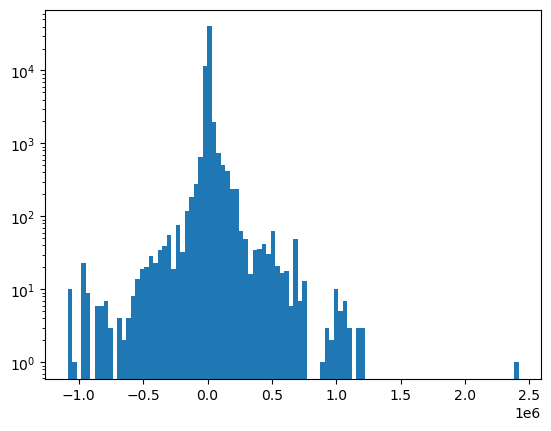

In [18]:
# plot a histogram of psfFluxes for all sources to see if there is something obvious
plt.hist(src4_field['psfFlux'].values, bins=100, log=True);

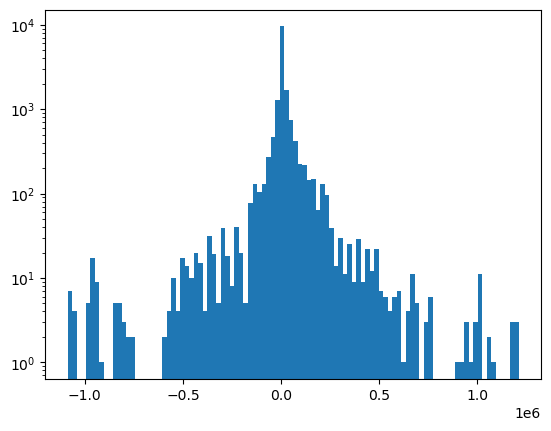

In [19]:
# plot a histogram of psfFluxes for all sources in objects that have more than 10 sources    to see if there is something obvious
filtered_df = src4_field[src4_field['diaObjectId'].isin(obj4_many_g['diaObjectId'])]

plt.hist(filtered_df['psfFlux'].values, bins=100, log=True);

In [20]:
# select the first source from the i-band list
psfFlux = src4_field[src4_field['diaObjectId']==3068394109505896788]['psfFlux']
band = src4_field[src4_field['diaObjectId']==3068394109505896788]['band']
np.sum(psfFlux>0)/len(psfFlux)

1.0

In [21]:
# find the earliest observation, so we can normalize to it
min_mjd = src4_field['midpointMjdTai'].min()

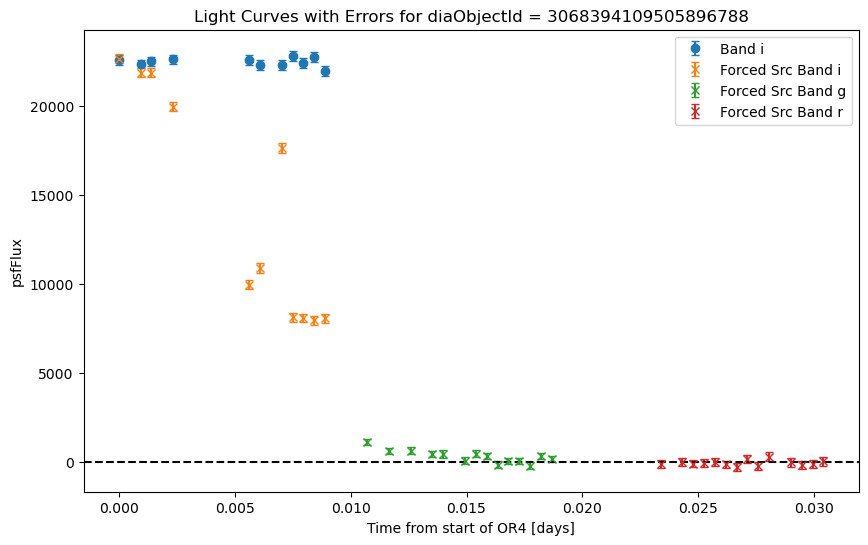

In [85]:
diaObjectId = 3068394109505896788

# Filter the data for the specific diaObjectId
mjd = src4_field[src4_field['diaObjectId'] == diaObjectId]['midpointMjdTai']
psfFlux = src4_field[src4_field['diaObjectId'] == diaObjectId]['psfFlux']
psfFluxErr = src4_field[src4_field['diaObjectId'] == diaObjectId]['psfFluxErr']
band = src4_field[src4_field['diaObjectId'] == diaObjectId]['band']

# Filter the forced data for the specific diaObjectId
mjdForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['midpointMjdTai']
psfFluxForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['psfFlux']
psfFluxErrForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['psfFluxErr']
bandForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['band']

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Get unique bands
unique_bands = band.unique()
unique_bandsForced = bandForced.unique()

# Plot each band with a different color and error bars
for b in unique_bands:
    band_mask = band == b
    plt.errorbar(mjd[band_mask] - min_mjd, psfFlux[band_mask], yerr=psfFluxErr[band_mask],
                 label=f'Band {b}', fmt='o', capsize=3)

# Plot each band with a different color and error bars
for b in unique_bandsForced:
    band_mask_forced = bandForced == b
    plt.errorbar(mjdForced[band_mask_forced] - min_mjd, psfFluxForced[band_mask_forced], yerr=psfFluxErrForced[band_mask_forced],
                 label=f'Forced Src Band {b}', fmt='x', capsize=3)

# Add labels and title
plt.xlabel('Time from start of OR4 [days]')
plt.ylabel('psfFlux')
plt.title('Light Curves with Errors for diaObjectId = 3068394109505896788')
plt.legend()
plt.axhline(0, color='black', linestyle='--')

# Show the plot
plt.show()

In [23]:
nv_collections = ['LSSTComCamSim/runs/nightlyValidation/20240625/w_2024_25/DM-44966',
                  'LSSTComCamSim/runs/nightlyValidation/20240626/w_2024_25/DM-44966',
                  'LSSTComCamSim/runs/nightlyValidation/20240627/w_2024_25/DM-44966']
drp_collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25',
                  'LSSTComCamSim/prompt/output-2024-06-26',
                  'LSSTComCamSim/prompt/output-2024-06-27']
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)


In [87]:
# example of source that is always there
single_src = src4_field[src4_field['diaObjectId'] == diaObjectId].iloc[0]
# single_src = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[25]

visit_id = single_src['visit']

# visit_id = 7024062500249
detector_id = single_src['detector']
print(visit_id, detector_id, single_src['band'])

one_pp_diaSrcTable = pp_butler.get('goodSeeingDiff_diaSrcTable', dataId={'detector': detector_id, 'visit': visit_id})
one_pp_diffim = pp_butler.get('goodSeeingDiff_differenceExp', dataId={'detector': detector_id, 'visit': visit_id})

one_pp_science = pp_butler.get('initial_pvi', dataId={'detector': detector_id, 'visit': visit_id})
one_pp_template = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': detector_id, 'visit': visit_id})


7024062500192 1 i


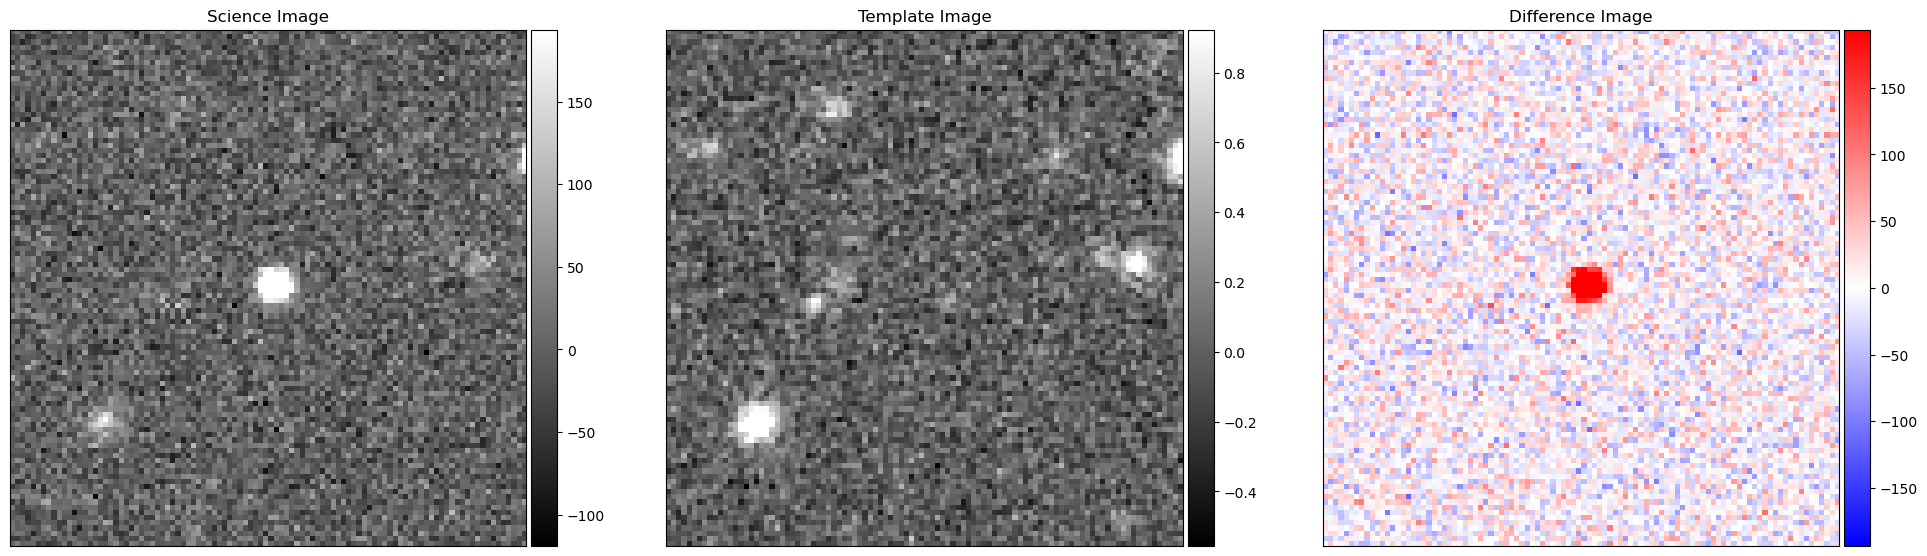

In [88]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))

# Define the region of interest
x_center = int(single_src['y'])
y_center = int(single_src['x'])
x_range = 50
y_range = 50

# Slice the region of interest
science_image = one_pp_science.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range]
template_image = one_pp_template.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range]
diffim_image = one_pp_diffim.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range]

# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_image, interval=ZScaleInterval())
norm_template = ImageNormalize(template_image, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)

# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(one_pp_science.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range], origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(one_pp_template.image.array[x_center-x_range+20:x_center+x_range+20, y_center-y_range+20:y_center+y_range+20], origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(one_pp_diffim.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range], origin='lower', norm=norm_diffim, cmap='bwr')

# Plot scatter points on ax3
# ax3.scatter(one_pp_diaSrcTable.x, one_pp_diaSrcTable.y, alpha=0.5, s=2)

# Set axis limits for ax3 to zoom into the region of interest
#ax3.set_xlim([x_center - x_range, x_center + x_range])
# ax3.set_ylim([y_center - y_range, y_center + y_range])

# Hide the axis ticks for all subplots
for ax in [ax1, ax2, ax3]:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')

# Show the plot
plt.show()

# example of an image of all positive source

In [89]:
# lets try to get template images for this one particular source
single_src_Forced_g = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[0]
print(single_src_Forced_g['diaObjectId'], single_src_Forced_g['ra'], single_src_Forced_g['dec'], single_src_Forced_g['band'], single_src_Forced_g['visit'])
one_pp_template_g = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': single_src_Forced_g['detector'], 'visit': single_src_Forced_g['visit']})

single_src_Forced_r = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[37]
print(single_src_Forced_r['diaObjectId'], single_src_Forced_r['ra'], single_src_Forced_r['dec'], single_src_Forced_r['band'], single_src_Forced_r['visit'])
one_pp_template_r = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': single_src_Forced_r['detector'], 'visit': single_src_Forced_r['visit']})

single_src_Forced_i = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[25]
print(single_src_Forced_i['diaObjectId'], single_src_Forced_i['ra'], single_src_Forced_i['dec'], single_src_Forced_i['band'], single_src_Forced_i['visit'])
one_pp_template_i = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': single_src_Forced_i['detector'], 'visit': single_src_Forced_i['visit']})



3068394109505896788 215.96731561264195 -12.767911407794355 i 7024062500190
3068394109505896788 215.96755318185288 -12.768034846536322 r 7024062500239
3068394109505896788 215.96755318185288 -12.768034846536322 g 7024062500220


In [30]:
close_tru_obj = tru_var_obj[(tru_var_obj['ra']<single_src_Forced_g['ra']+0.02) & (tru_var_obj['ra']>single_src_Forced_g['ra']-0.02) & (tru_var_obj['dec']<single_src_Forced_g['dec']+0.02) & (tru_var_obj['dec']>single_src_Forced_g['dec']-0.02)]

In [31]:
center = lsst.geom.SpherePoint(single_src_Forced_i['ra'], single_src_Forced_i['dec'], lsst.geom.degrees)
# center = lsst.geom.SpherePoint(close_tru_obj['ra'].values[0], close_tru_obj['dec'].values[0], lsst.geom.degrees)
s = 200
extent = lsst.geom.Extent2I(s, s)

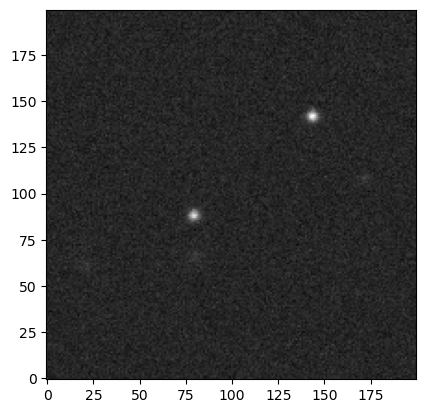

In [32]:
single_src_Forced_r = srcForced4_field[srcForced4_field['diaForcedSourceId'] == 3068394172860858422]
#nothing in r
one_pp_science_r = pp_butler.get('initial_pvi', dataId={'detector': single_src_Forced_r['detector'].values[0], 'visit': single_src_Forced_r['visit'].values[0]})
science_cutout = one_pp_science_r.getCutout(center, extent)

# TODO show in i-band and g-band


plt.imshow(science_cutout.image.array, origin='lower', cmap='gray')

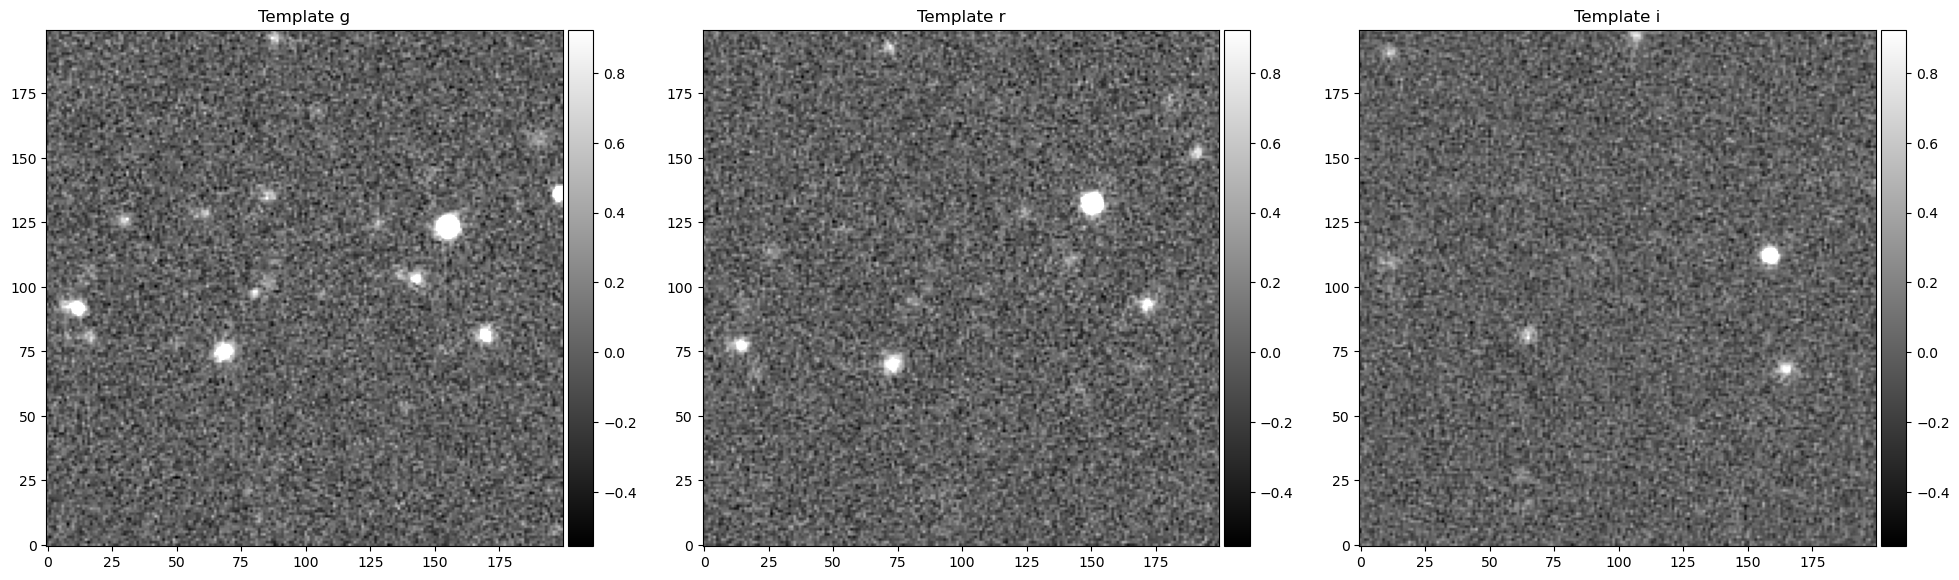

In [33]:
template_g_cutout = one_pp_template_g.getCutout(center, extent)
template_r_cutout = one_pp_template_r.getCutout(center, extent)
template_i_cutout = one_pp_template_i.getCutout(center, extent)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(template_g_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')
img2 = ax2.imshow(template_r_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(template_i_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Template g')
ax2.set_title('Template r')
ax3.set_title('Template i')

# Show the plot
plt.show()



In [34]:
# what am I looking for here - I think I am looking if the objects is in list of actual variable objects
# but it might be in the list of nonvariable objects!!!!
# TODO: check that

df_obj = obj4_field[obj4_field['diaObjectId'] == 3068394109505896788]
tru_obj = tru_var_obj
match_value = 1
# all of the diaObjects in a field
dia_obj_SC = SkyCoord(ra=df_obj['ra'].values*u.degree, dec=df_obj['dec'].values*u.degree) 
# all of the variable objects in a field
tru_obj_SC = SkyCoord(ra=tru_obj['ra'].values*u.degree, dec=tru_obj['dec'].values*u.degree)
# match the observations to the truth
idx, d2d, d3d = tru_obj_SC.match_to_catalog_sky(dia_obj_SC)
# index of all diaObj that are within match_value of a true variable object
idx_close = idx[d2d.to(u.arcsec).value<match_value]
print(np.min(d2d.to(u.arcsec).value))
# all of diaObjects thare are within match_value of a variable object
matches_close = df_obj.iloc[idx_close]
matches_close

50.60129401651837


,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources


In [35]:
# Assuming d2d.to(u.arcsec).value is a numpy array
values = np.array(d2d.to(u.arcsec).value)

# Find the index of the minimum value
min_index = np.argmin(values)
tru_obj.iloc[min_index]


object_type                                               star
id                                                  1009899244
ra                                                  215.956136
dec                                                 -12.776613
host_galaxy_id                                               0
magnorm                                               21.39623
sed_filepath         starSED/kurucz/km20_5500.fits_g15_5560.gz
MW_rv                                                      3.1
MW_av                                                 0.272701
mura                                                     -1.36
mudec                                                    -3.07
radial_velocity                                         239.06
parallax                                              0.080427
variability_model                                             
salt2_params                                              None
is_variable                                            

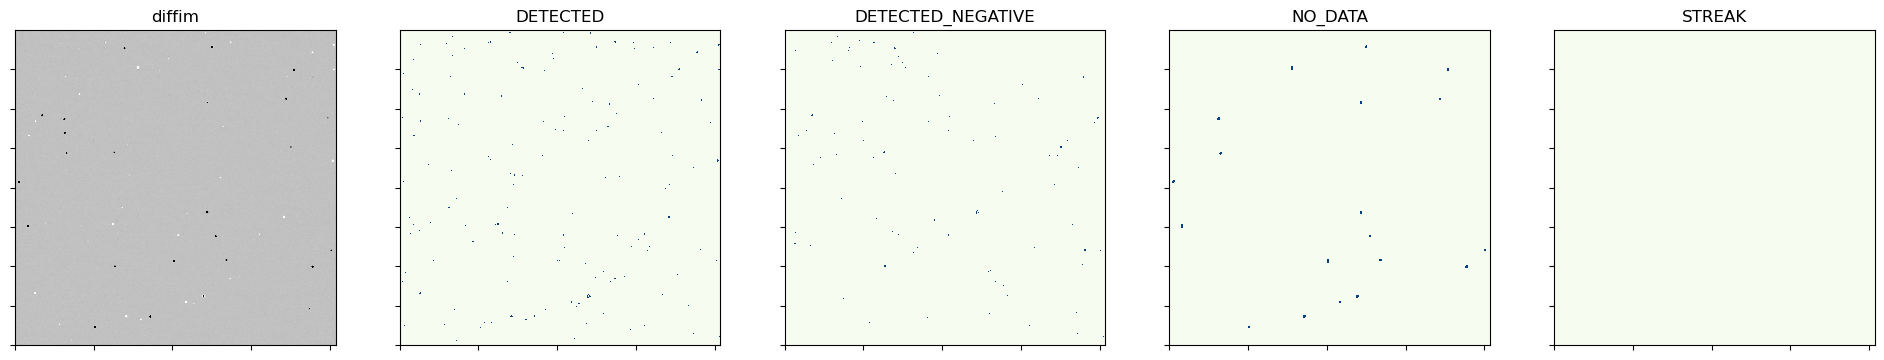

In [36]:
plotFlagImages(one_pp_diffim)


In [38]:
obj4_more_10 = obj4_field_with_band_counts[
    (obj4_field_with_band_counts['nDiaSources_g'] > 10) | 
    (obj4_field_with_band_counts['nDiaSources_i'] > 10) | 
    (obj4_field_with_band_counts['nDiaSources_r'] > 10)
]
obj4_more_10 = obj4_more_10.copy(deep=True)
obj4_more_10

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources,nDiaSources_g,nDiaSources_i,nDiaSources_r
44,3068394109505896706,2024-06-26 02:58:21+00:00,0,215.988803,6.051799e-06,-12.846673,6.745328e-06,2.462018e-12,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:43+00:00,26,11,6,9
55,3068394109505896720,2024-06-26 02:58:21+00:00,0,216.011773,2.798506e-06,-12.842626,2.892115e-06,3.922076e-14,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:43+00:00,31,12,7,12
57,3068394109505896722,2024-06-26 02:58:21+00:00,0,215.994210,2.229718e-06,-12.836417,2.346040e-06,9.453771e-14,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:43+00:00,31,12,7,12
72,3068394109505896739,2024-06-26 02:58:21+00:00,0,215.986590,1.213741e-06,-12.818173,1.229305e-06,-1.450207e-14,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:43+00:00,29,12,8,9
73,3068394109505896740,2024-06-26 02:58:21+00:00,0,215.976909,5.093655e-06,-12.814752,5.430930e-06,7.737264e-13,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:43+00:00,34,14,8,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,3068394156758925466,2024-06-26 02:56:33+00:00,0,215.980679,1.737560e-05,-12.557215,1.494686e-05,-2.479273e-11,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:11+00:00,14,0,0,14
8120,3068394157841055842,2024-06-26 02:55:40+00:00,0,215.979755,2.396693e-07,-12.300577,2.437930e-07,-1.814534e-16,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:26+00:00,14,0,0,14
8371,3068394159984345218,2024-06-26 02:55:37+00:00,0,216.101265,6.951838e-06,-12.435812,7.353275e-06,6.492552e-13,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:26+00:00,11,0,0,11
8381,3068394159988539507,2024-06-26 02:56:33+00:00,0,215.985925,8.232452e-06,-12.448405,8.986657e-06,1.844188e-12,60487.119709,0,...,0,0,0,0,0,2024-06-26 02:55:11+00:00,12,0,0,12


In [39]:
fractions_g = []
fractions_r = []
fractions_i = []

# Loop over each row in obj4_more_10
for index, row in obj4_more_10.iterrows():
    diaObjectId = row['diaObjectId']
    
    # For each band (g, r, i), filter the rows in src4_field that match the diaObjectId and the band
    for band, fractions_list in zip(['g', 'r', 'i'], [fractions_g, fractions_r, fractions_i]):
        # Get the matching rows for the current diaObjectId and band
        matching_rows = srcForced4_field[(srcForced4_field['diaObjectId'] == diaObjectId) & (srcForced4_field['band'] == band)]
        
        # Extract the psfFlux values for the matching rows
        psfFlux_values = matching_rows['psfFlux']
        
        # Calculate the fraction of psfFlux values greater than 0
        if len(psfFlux_values) > 0:
            fraction_positive = (psfFlux_values > 0).sum() / len(psfFlux_values)
        else:
            fraction_positive = np.nan  # Set to NaN if there are no observations in that band
        
        # Append the result to the corresponding fractions list
        fractions_list.append(fraction_positive)

# Add the fractions as new columns in obj4_more_10
# Now, safely assign the new columns using .loc to avoid the warning
obj4_more_10['fraction_positive_psfFlux_g'] = fractions_g
obj4_more_10['fraction_positive_psfFlux_r'] = fractions_r
obj4_more_10['fraction_positive_psfFlux_i'] = fractions_i

In [40]:
srcForced4_field

,diaForcedSourceId,diaObjectId,ra,dec,visit,detector,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,band
0,3068394139604222223,3068394112760676368,215.880902,-12.369143,7024062500218,8,60487.103777,-215.352280,293.418518,118478.304688,280.510254,g
1,3068394109505896597,3068394109505896606,215.888972,-12.896921,7024062500190,0,60487.089310,-3684.523193,340.249725,69499.117188,323.690247,i
2,3068394122394992815,3068394109505896606,215.888995,-12.896913,7024062500202,1,60487.094933,-2158.574463,361.834412,72103.179688,348.425873,i
3,3068394109505896607,3068394109505896616,215.920580,-12.899914,7024062500190,0,60487.089310,2953.202637,382.264618,146486.218750,365.588196,i
4,3068394122394992816,3068394109505896616,215.920580,-12.899914,7024062500202,1,60487.094933,-885.210938,430.141083,177814.968750,416.574249,i
...,...,...,...,...,...,...,...,...,...,...,...,...
222053,3068394163192988382,3068394112727122057,216.204005,-12.870464,7024062500240,0,60487.115497,2039.768677,222.082443,3142.970459,205.965271,r
222054,3068394154603053345,3068394112727122061,216.312315,-12.897215,7024062500232,0,60487.111744,10167.688477,316.825134,33572.269531,288.390839,r
222055,3068394161045504451,3068394112727122061,216.312316,-12.897216,7024062500238,0,60487.114560,8562.610352,287.237671,32946.242188,261.588715,r
222056,3068394154603053099,3068394112727122062,216.256485,-12.881426,7024062500232,0,60487.111744,1330.667114,422.234924,118827.078125,383.545654,r


In [93]:
# objects that have more than 10 observations in i-band and all negative detections
obj4_more_10[(obj4_more_10['fraction_positive_psfFlux_i']==0) & (obj4_more_10['nDiaSources_i']>10)]

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources,nDiaSources_g,nDiaSources_i,nDiaSources_r,fraction_positive_psfFlux_g,fraction_positive_psfFlux_r,fraction_positive_psfFlux_i
468,3068394109518479375,2024-06-26 02:58:21+00:00,0,216.105046,0.0,-12.767740,0.0,0.0,60487.119709,0,...,0,0,2024-06-26 02:56:11+00:00,40,14,11,15,0.000000,0.000000,0.0
469,3068394109518479376,2024-06-26 02:58:21+00:00,0,216.109929,0.0,-12.767961,0.0,0.0,60487.119709,0,...,0,0,2024-06-26 02:56:11+00:00,41,14,12,15,0.000000,0.000000,0.0
479,3068394109518479387,2024-06-26 02:26:12+00:00,0,215.996853,0.0,-12.718398,0.0,0.0,60487.098207,0,...,0,0,2024-06-26 02:24:30+00:00,12,0,12,0,0.312500,0.187500,0.0
490,3068394109518479398,2024-06-26 02:58:21+00:00,0,216.120004,0.0,-12.747814,0.0,0.0,60487.119709,0,...,0,0,2024-06-26 02:56:11+00:00,39,13,12,14,0.000000,0.000000,0.0
511,3068394109518479425,2024-06-26 02:58:21+00:00,0,216.152628,0.0,-12.738105,0.0,0.0,60487.119709,0,...,0,0,2024-06-26 02:56:11+00:00,31,5,11,15,0.000000,0.000000,0.0
513,3068394109518479427,2024-06-26 02:58:21+00:00,0,216.092711,0.0,-12.715737,0.0,0.0,60487.119709,0,...,0,0,2024-06-26 02:56:11+00:00,41,16,12,13,0.000000,0.000000,0.0
552,3068394109518479476,2024-06-26 02:56:11+00:00,0,216.113010,0.0,-12.683243,0.0,0.0,60487.119709,0,...,0,0,2024-06-26 02:55:46+00:00,28,0,12,16,0.000000,0.000000,0.0
558,3068394109518479482,2024-06-26 02:55:16+00:00,0,215.980706,0.0,-12.637042,0.0,0.0,60487.119240,0,...,0,0,2024-06-26 02:54:41+00:00,32,3,12,17,0.000000,0.000000,0.0
580,3068394109518479510,2024-06-26 02:56:11+00:00,0,216.162234,0.0,-12.676301,0.0,0.0,60487.119709,0,...,0,0,2024-06-26 02:55:46+00:00,45,15,13,17,0.000000,0.000000,0.0
582,3068394109518479512,2024-06-26 02:56:33+00:00,0,216.021439,0.0,-12.630048,0.0,0.0,60487.119709,0,...,0,0,2024-06-26 02:54:41+00:00,47,19,11,17,0.000000,0.000000,0.0
